# FIT5196 Data Wrangling - S2 2016
 
## Assessment 2 - Data Cleansing
 
Filename: International_Disasters_data_cleansing.ipynb
 
Author: Lynn Miller
 
Date: 28-Aug-2016
 
Version: 1.0
 
Language: Python 2.7.12 and Jupyter notebook Anaconda 2

Libraries used:
- `pandas`: for data frames
- `numpy`: for numpy arrays
- `datetime`: for datetime data types
- `matplotlib`: for plotting methods
- `sklearn.crossvalidation`: to split data into test and training datasets
 
## Introduction

This code is developed to cleanse the disasters dataset and performs the following tasks:
 
**Task 1: Data auditing -** Identifies and fixes some common data problems.

**Task 2: Identify outliers -** Finds outliers for people killed in South African disasters using boxplots and the Hampel identifier.  

**Task 3: Deal with missing data -** Deletes rows and columns containing many missing values. Imputes missing values in the "impact_area" column using linear regression. This requires imputation of missing values in the "Killed" and "Affected" columns.

## Resources Used

- Online Python Documentation - https://docs.python.org/2/index.html
- Online Pandas Documentation - http://pandas.pydata.org/pandas-docs/stable/index.html
- Chris Albon for information about using crosstabs - http://chrisalbon.com/python/pandas_crosstabs.html
- Data Science Lab for information about customising pandas plots - https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/

## Initialisation 

Import the libraries used:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split

Read the input file. "Start" and "End" (which are dates mainly in ddmmyyyy format) are kept as string data type for ease of handling in later steps. 

In [2]:
# Read the file
data = pd.read_csv("Data.csv",index_col=0,dtype={"Start":"object","End":"object"})
# Show the attribute names and types
data.dtypes

Start                     object
End                       object
Country                   object
Location                  object
Type                      object
Sub_Type                  object
Names                     object
Killed                   float64
Affected                 float64
Cost                     float64
International support    float64
ID                        object
Impact_area              float64
dtype: object

Display a summary of the dataframe attributes

In [3]:
# Summary of the numeric columns
data[["Killed","Affected","Cost","International support","Impact_area"]].apply(lambda x: x.dropna().describe())

,Killed,Affected,Cost,International support,Impact_area
count,1.130100e+04,8.884000e+03,3027.000000,6928.000000,6.928000e+03
mean,2.802027e+03,5.915656e+05,482.783997,1014.587596,1.955000e+04
std,7.755262e+04,7.240275e+06,3319.931382,446.295287,2.348441e+05
min,1.000000e+00,1.000000e+00,0.003000,0.000000,0.000000e+00
25%,1.200000e+01,6.000000e+01,5.000000,696.874000,1.517500e+01
50%,2.400000e+01,1.000000e+03,35.000000,1075.318000,3.915500e+01
75%,5.600000e+01,2.000000e+04,200.000000,1323.537250,6.110200e+02
max,5.000000e+06,3.000000e+08,125000.000000,2801.093000,1.073480e+07


In [4]:
# Summary of the string columns
data.describe(include=["object"])

,Start,End,Country,Location,Type,Sub_Type,Names,ID
count,14350,14350,14350,12458,14350,12515,4558,14350
unique,7947,7974,228,10553,18,46,2226,13694
top,72000,1983,China,North,Transport Accident,Road,Cholera,2005-0713
freq,23,31,1042,59,3367,1565,287,21


## Task 1: Data Auditing

### Fix Lexical Errors

#### Lexical Errors in Country Names

This step checks for and corrects misspelt or incorrect country names in the "Countries" attribute.

##### Find the Problem Records

Assuming that the same lexical error would not be made more than a couple of times, so inspect the list of Countries with only one or two records to find any errors. 

In [5]:
# Display a list of countries with one or two records
data.Country.value_counts()[data.Country.value_counts() < 3]

Timor-Leste                      2
Kuwait                           2
Palestine (West Bank)            2
Seychelles                       2
St Helena                        1
Palau                            1
Chine                            1
St Vincent and the Grenadines    1
Bahrain                          1
Virgin Is (UK)                   1
United Stats                     1
Wallis                           1
Northern Mariana Is              1
Mayotte                          1
French Guiana                    1
Name: Country, dtype: int64

This list shows the misspellings "Chine" and "United Stats", also the value "Wallis", which does not appear to be a country.

Have these errors occurred in columns other than Country?

In [6]:
# Get a list of the string columns
dataStrCols = data.columns[data.dtypes == "object"].tolist()
# Search the string columns for these misspellings
problemCountries = data[dataStrCols].apply(lambda x: x.str.match(".*(?:Chine|United Stats|Wallis)",
                                                                 na=False, as_indexer=True)).any(axis=1)
# Search the string columns for these misspellings
data.loc[problemCountries,dataStrCols].sort_values("Country")

,Start,End,Country,Location,Type,Sub_Type,Names,ID
7332,15081991,15081991,China,Mer de Chine méridionale,Transport Accident,Water,Boat 'Mcdermott Derrick 29',1991-0620
7512,15081991,15081991,China,Mer de Chine méridionale,Transport Accident,Water,Vraquier 'Petchomphoo',1991-0621
10131,22121991,22121991,Chine,Mer de Chine méridionale,Transport Accident,Water,Cargo 'Amie V',1991-0629
951,28061992,28061992,United Stats,Landers California,Earthquake (seismic activity),Earthquake (ground shaking),NaN,1992-0215
3422,13031993,13031993,Wallis,Futuna Isl.,Earthquake (seismic activity),Earthquake (ground shaking),NaN,1993-0134
10907,25121986,25121986,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,Raja,1986-0142
11345,5021965,5021965,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,NaN,1965-0010
11917,29011966,29011966,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,NaN,1966-0023


In [7]:
# Check these names for leading/trailing spaces
print data.Country[problemCountries].apply(lambda x: ":"+x+":")

951              :United Stats:
3422                  :Wallis :
7332                    :China:
7512                    :China:
10131                   :Chine:
10907    :Wallis and Futuna Is:
11345    :Wallis and Futuna Is:
11917    :Wallis and Futuna Is:
Name: Country, dtype: object


In addition to not being a country, "Wallis" has a trailing space.

##### Fix the Errors

The records flagged above need the following changes:

| Attribute | Misspelling              | Correct Name         | Comment                                           |
|-----------|--------------------------|----------------------|---------------------------------------------------|
| Country   | Chine                    | China                | Could be a misspelling of either China or Chile, but a quick internet search shows that the location "Mer de Chine méridionale" is the French name for "South China Sea"           |
| Location  | Mer de Chine méridionale | South China Sea      | Change the French name in the Location to English |
| Country   | United Stats             | United States        | Correct Stats to States                           |
| Country, Location | Wallis                   | Wallis and Futuna Is | Wallis has a trailing space and the country "Wallis and Futuna Is" has been split across the Country and Location fields - correct the country and remove the location            |
| Country   | Wallis and Futuna Is     | Wallis and Futuna Is | Not an error - no change required                 |


In [8]:
# Correct the incorrect country names
data.loc[data.Country == "Chine","Country"] = "China"
data.loc[data.Location == "Mer de Chine méridionale","Location"] = "South China Sea"
data.loc[data.Country == "United Stats","Country"] = "United States"
data.loc[data.Country == "Wallis ","Location"] = np.nan
data.loc[data.Country == "Wallis ","Country"] = "Wallis and Futuna Is"

# Check the updated records
data.loc[problemCountries,dataStrCols].sort_values("Country")

,Start,End,Country,Location,Type,Sub_Type,Names,ID
7332,15081991,15081991,China,South China Sea,Transport Accident,Water,Boat 'Mcdermott Derrick 29',1991-0620
7512,15081991,15081991,China,South China Sea,Transport Accident,Water,Vraquier 'Petchomphoo',1991-0621
10131,22121991,22121991,China,South China Sea,Transport Accident,Water,Cargo 'Amie V',1991-0629
951,28061992,28061992,United States,Landers California,Earthquake (seismic activity),Earthquake (ground shaking),NaN,1992-0215
3422,13031993,13031993,Wallis and Futuna Is,NaN,Earthquake (seismic activity),Earthquake (ground shaking),NaN,1993-0134
10907,25121986,25121986,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,Raja,1986-0142
11345,5021965,5021965,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,NaN,1965-0010
11917,29011966,29011966,Wallis and Futuna Is,NaN,Storm,Tropical cyclone,NaN,1966-0023


#### Remove Leading and Trailing Spaces

One of the above issues was due to a trailing space in the Country, do other columns have a similar problem - or have leading spaces?

##### Find the Problem Records

Search the string attributes and print counts of records with a leading or trailing space

In [9]:
print "Number of values with leading/trailing spaces"
for col in dataStrCols:
    print col, ":", data[col].str.match(r"(?:^ +.*)|(?:.* +$)", na=False, as_indexer=True).sum()

Number of values with leading/trailing spaces
Start : 0
End : 0
Country : 0
Location : 147
Type : 0
Sub_Type : 0
Names : 16
ID : 0


##### Fix the Errors

Remove any leading and trailing spaces from Location and Names values

In [10]:
# Remove leading and trailing spaces from Location
data["Location"] = data.Location.str.strip()

# Remove leading and trailing spaces from Names
data["Names"] = data.Names.str.strip()

# Check for any remaining records with leading or trailing spaces
print "Number of values with leading/trailing spaces"
for col in dataStrCols:
    print col, ":", data[col].str.match(r"(?:^ +.*)|(?:.* +$)", na=False, as_indexer=True).sum()

Number of values with leading/trailing spaces
Start : 0
End : 0
Country : 0
Location : 0
Type : 0
Sub_Type : 0
Names : 0
ID : 0


### Fix Irregularities

#### Incomplete Dates

The majority of Start and End dates are in the format ddmmyyyy, but some are missing the day and month components. To enable the Start and End columns to be recognised as dates, they all need to be in the same format. This is done in two steps:
1. Check all dates are eight characters
2. Check the day, month and year components are valid

This step checks for and corrects Start and End dates that have fewer than eight characters.

##### Find the Problem Records

A simple check of the length of the Start and End values is made to identify records without complete dates. As there are a large number of these records, only the first few are displayed.

In [11]:
# Display the first few Start records with fewer than 8 characters
data.Start[data.Start.str.len() < 8].head(10)

1     8092004
3       21983
4        1983
8       81986
15    9082003
16    2082000
19    4122004
22      12004
23      41982
24     122000
Name: Start, dtype: object

In [12]:
# Display the first few End records with fewer than 8 characters
data.End[data.End.str.len() < 8].head(10)

1     8092004
3       21983
4        1983
8       81986
19    4122004
22       2004
23      41982
24     122000
26    9052000
29    5082005
Name: End, dtype: object

##### Fix the Start Dates

Start dates are fixed using the following rules:
1. If the length of Start is 4, assume that just the year has been specified. Set the date to 1st January of the given year.
2. If the length of Start is 5, the day is missing and the month is missing a leading 0. Prefix with "010" to set the date to 1st of the specified month/year.
3. If the length of Start is 6, the day is missing. Set the date to the 1st of the specified month/year.
4. If the length of Start is 7, the day is missing a leading 0. Prefix the date with "0".

In [13]:
# Fix records where Start has less than 8 characters
data.loc[data.Start.str.len() == 4,"Start"] = "0101" + data.Start[data.Start.str.len() == 4]
data.loc[data.Start.str.len() == 5,"Start"] = "010" + data.Start[data.Start.str.len() == 5]
data.loc[data.Start.str.len() == 6,"Start"] = "01" + data.Start[data.Start.str.len() == 6]
data.loc[data.Start.str.len() == 7,"Start"] = "0" + data.Start[data.Start.str.len() == 7]

# Check the results by displaying the first few values
data.Start.head(10)

0    10061965
1    08092004
2    15031995
3    01021983
4    01011983
5    26071996
6    19062003
7    16022003
8    01081986
9    13102007
Name: Start, dtype: object

##### Fix the End Dates

End dates are fixed using the following rules:
1. If the length of End is 4, assume that just the year has been specified. Set the date to 31st December of the given year.
2. If the length of Start is 5, the day is missing and the month is missing a leading 0. Prefix with "0" and use the lastDay method to set the date to last day of the specified month/year.
3. If the length of Start is 6, the day is missing. Use the lastDay method to set the date to last day of the specified month/year.
4. If the length of Start is 7, the day is missing a leading 0. Prefix the date with "0".

#### Method to find the Last Day of the Month

Method Name: lastDay

Input Parameters:
- value - a string containing the month in MMYYYY format

Return Value:
- a string containing the last day in the month in DDMMYYYY format

Description:

If the month is February in a leap year, returns the month prefixed with "29".

Otherwise extracts the month from the input value and uses that to retrieve the number of days in the month from monthDict.  Returns the input month prefixed with the last day of the month.

In [14]:
# Dictionary that specifies the number of days in each month
monthDict = {"01":"31", "02":"28", "03":"31", "04":"30", "05":"31", "06":"30",
             "07":"31", "08":"31", "09":"30", "10":"31", "11":"30", "12":"31"}

def lastDay(value):
    if ((value[0:2] == "02") & (int(value)%4 == 0)):
        return "29" + value
    else:
        return monthDict[value[0:2]] + value

In [15]:
# Fix records where End has less than 8 characters
data.loc[data.End.str.len() == 4,"End"] = "3112" + data.End[data.End.str.len() == 4]
data.loc[data.End.str.len() == 5,"End"] = ("0" + data.End[data.End.str.len() == 5]).apply(lastDay)
data.loc[data.End.str.len() == 6,"End"] = data.End[data.End.str.len() == 6].apply(lastDay)
data.loc[data.End.str.len() == 7,"End"] = "0" + data.End[data.End.str.len() == 7]

# Check the results by displaying the first few values
data.End.head(10)

0    10061965
1    08092004
2    15031995
3    28021983
4    31121983
5    26071996
6    19062003
7    22022003
8    31081986
9    13102007
Name: End, dtype: object

#### Invalid Dates

Check to see if any of the "Start" or "End" values are invalid dates

##### Find the Problem Records

Attempt to convert the "Start" and "End" values to dates and report the ones that raise an error

#### Method to Check Dates

Method Name: checkDate

Input Parameters:
- value - a string containing the date to check

Return Value:
- A boolean value indicating whether or not the string is a valid date

Description:

Calls the strptime method to attempt to convert the value to a date. Returns True if the call was successful. Returns false if strptime raises an exception.

In [16]:
def checkDate(value):
    try: 
        # Attempt to convert the value to a date
        dt.datetime.strptime(value, "%d%m%Y") 
        # Return true if the value is a valid date
        return True
    # Catch exceptions from strptime
    except:
        # Return false if the value is not a valid date
        return False

In [17]:
# Find records with an invalid start date
data.loc[~ data.Start.apply(checkDate),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
8419,31091992,31091992,Afghanistan,Salang:Ghorband:Shutul ...,Flood,Flash flood,NaN,450.0,4000.0,4.0,562.488,1992-0063,168.56


In [18]:
# Find records with an invalid end date
data.loc[~ data.End.apply(checkDate),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
110,08091992,31091992,India,Uttar Pradesh:Jammu:Mad ...,Flood,General flood,NaN,500.0,70000.0,57.85,521.220,1992-0083,2536.73
4807,01111996,31041997,Sierra Leone,Kenema District,Epidemic,Viral Infectious Diseases,Lassa fever,110.0,470.0,NaN,1359.351,1996-0491,37.98
8419,31091992,31091992,Afghanistan,Salang:Ghorband:Shutul ...,Flood,Flash flood,NaN,450.0,4000.0,4.00,562.488,1992-0063,168.56
12067,01011998,31021998,Peru,Arequipa:Lima:La Libert ...,Epidemic,Bacterial Infectious Diseases,Cholera,16.0,2863.0,NaN,1389.495,1998-0570,129.21


There are a few records that have the date as the 31st of a month with less than 31 days.

##### Fix the Errors

Apply the lastDay method to records with an invalid day component to set the date to the last day of the month

In [19]:
# Extract the invalid start dates
badDates = ~ data.Start.apply(checkDate)

# Correct the invalid start dates
data.loc[badDates,"Start"] = data.Start[badDates].str.extract("^..(.{6})$", expand=False).apply(lastDay)

# Check the corrected values
data.loc[badDates,"Start"]

8419    30091992
Name: Start, dtype: object

In [20]:
# Extract the invalid end dates
badDates = ~ data.End.apply(checkDate)

# Correct the invalid end dates
data.loc[badDates,"End"] = data.End[badDates].str.extract("^..(.{6})$", expand=False).apply(lastDay)

# Check the corrected values
data.loc[badDates,"End"]

110      30091992
4807     30041997
8419     30091992
12067    28021998
Name: End, dtype: object

#### Irregularities in Names

Names attributes look like they should start with an alphanumeric value. Are there any that don't?

##### Find the Problem Records

Find records starting with a non-alphanumeric character:

In [21]:
data.loc[data.Names.str.match("^\W.*$", na=False, as_indexer=True),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
964,19071980,19071980,Philippines,NaN,Storm,Tropical cyclone,(Nitang/Osang),36.0,69237.0,NaN,1126.197,1980-0136,2474.42
992,20031980,20031980,Philippines,NaN,Storm,Tropical cyclone,(Biring),4.0,665.0,0.402,1125.763,1980-0132,1.23
1336,02121982,02121982,Philippines,Visayan Sea region,Storm,Tropical cyclone,(Aning),NaN,85.0,0.005,NaN,1982-0176,NaN
1859,26092002,26092002,Pakistan,Near Sibi (Quetta),Transport Accident,Rail,'Quetta Express',14.0,60.0,NaN,382.773,2002-0619,32.87
4754,24071999,24071999,South Africa,Mariannu,Transport Accident,Water,'Palli HJA',29.0,NaN,NaN,NaN,1999-0700,NaN
4950,22041980,22041980,Philippines,NaN,Transport Accident,Water,'Don Juan' and 'Pnoc Tanker',114.0,901.0,NaN,515.869,1980-0148,36.71
5044,05091982,05091982,Philippines,C./S. Luzon,Storm,Tropical cyclone,(Ruping),65.0,50008.0,NaN,1126.076,1982-0101,1810.13
5115,16071977,16071977,Philippines,NaN,Storm,Tropical cyclone,(Elang),4.0,863.0,NaN,0.000,1977-0155,59.49
5332,18041978,18041978,Philippines,NaN,Storm,Tropical cyclone,(Atang),66.0,81842.0,33.254,1126.277,1978-0158,2956.77
5753,17111981,17111981,Philippines,NaN,Storm,Tropical cyclone,(Yeyeng),4.0,5736.0,0.167,1125.795,1981-0138,202.71


There are several Tropical cyclones that have the name in parenthesis. Is this a consistent format?

In [22]:
# Get the number of named tropical cyclones
print "Number of named tropical cyclones:", ((data.Sub_Type == "Tropical cyclone") & data.Names.notnull()).sum()

# Get the number of tropical cyclone names in brackets
print "Number of bracketed tropical cyclone names:", ((data.Sub_Type == "Tropical cyclone") & data.Names.str.match("^\(.*\)$", na=False, as_indexer=True)).sum()

# Display the first few tropical cyclone names
data.Names[(data.Sub_Type == "Tropical cyclone") & data.Names.notnull()].head(20)

Number of named tropical cyclones: 1080
Number of bracketed tropical cyclone names: 16


0                              Dinah
1                               Ivan
17          Typhoon 'Hagupit' (Nina)
19             Nanmadol (Yoyong/30W)
85                             Betsy
118               Chedeng and Dodong
125                            David
126                           Damrey
137                            Pabuk
150                            Hudah
166                             Dean
170                          Giselle
172                             Joan
181                            Lilli
206                            Cliff
269                             Irma
305                              Dot
325    Tropical storm 'Nuri' (Karen)
346                      Gorky (02B)
361                              Dot
Name: Names, dtype: object

Only 16 out of 1080 named tropical cyclones have parenthesis around the entire name. 

##### Fix the Irregularities

Remove the parenthesis from the names of tropical cyclones affecting the Philippines so they are consistent with other records.

In [23]:
# Extract the names to fix
fixNames = data.Names[(data.Sub_Type == "Tropical cyclone") & data.Names.str.match(r"^\(.*\)$", na=False, as_indexer=True)]

# Fix the names
fixNames = fixNames.str.extract(r"^\((.*)\)$", expand=False)

# Update the names in the dataframe
data.loc[fixNames.index,"Names"] = fixNames

# Display the updated names
data.Names[fixNames.index]

964      Nitang/Osang
992            Biring
1336            Aning
5044           Ruping
5115            Elang
5332            Atang
5753           Yeyeng
5985           Heling
7578            Emang
9467            Akang
9843           Weling
10878         Garding
11057          Daling
13434          Ibiang
13715         Norming
13752          Mameng
Name: Names, dtype: object

Check the dataframe for the remaining names that do not start with an alphanumeric:

In [24]:
data.loc[data.Names.str.match("^\W.*$", na=False, as_indexer=True),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
1859,26092002,26092002,Pakistan,Near Sibi (Quetta),Transport Accident,Rail,'Quetta Express',14.0,60.0,NaN,382.773,2002-0619,32.87
4754,24071999,24071999,South Africa,Mariannu,Transport Accident,Water,'Palli HJA',29.0,NaN,NaN,NaN,1999-0700,NaN
4950,22041980,22041980,Philippines,NaN,Transport Accident,Water,'Don Juan' and 'Pnoc Tanker',114.0,901.0,NaN,515.869,1980-0148,36.71
9199,13062000,13062000,Pakistan,Near Jhampir,Transport Accident,Rail,'Awami Express' and shah Latif' passenger train,20.0,NaN,NaN,NaN,2000-0362,NaN
13209,18072006,18072006,United States,Florida,Transport Accident,Water,'Paquebot 'Crown princess',NaN,100.0,NaN,NaN,2006-0399,NaN


Most of these are names of vehicles in quotes - which seems consistent. But remove the leading quote in the last record.

In [25]:
# Correct the name
data.loc[data.Names == "'Paquebot 'Crown princess'","Names"] = "Paquebot 'Crown princess'"

# Re-run the check
data.loc[data.Names.str.match("^\W.*$", na=False, as_indexer=True),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
1859,26092002,26092002,Pakistan,Near Sibi (Quetta),Transport Accident,Rail,'Quetta Express',14.0,60.0,NaN,382.773,2002-0619,32.87
4754,24071999,24071999,South Africa,Mariannu,Transport Accident,Water,'Palli HJA',29.0,NaN,NaN,NaN,1999-0700,NaN
4950,22041980,22041980,Philippines,NaN,Transport Accident,Water,'Don Juan' and 'Pnoc Tanker',114.0,901.0,NaN,515.869,1980-0148,36.71
9199,13062000,13062000,Pakistan,Near Jhampir,Transport Accident,Rail,'Awami Express' and shah Latif' passenger train,20.0,NaN,NaN,NaN,2000-0362,NaN


#### Killed or Affected not Integers

Are there any Killed or Affected values that are not integers?

In [26]:
# Check for Killed values that have a decimal component
print data[pd.notnull(data.Killed) & (data.Killed % 1 != 0)]

# Check for Affected values that have a decimal component
print data[pd.notnull(data.Affected) & (data.Affected % 1 != 0)]

Empty DataFrame
Columns: [Start, End, Country, Location, Type, Sub_Type, Names, Killed, Affected, Cost, International support, ID, Impact_area]
Index: []
Empty DataFrame
Columns: [Start, End, Country, Location, Type, Sub_Type, Names, Killed, Affected, Cost, International support, ID, Impact_area]
Index: []


Nothing fails this check - no corrections to Killed or Affected to make

#### ID is not YYYY-nnnn Format

The ID appears to be a year followed by a 4-digit number seperate by a hyphen. Are any IDs not in this format?

In [27]:
# Check for ID's in non-standard format
print data[~ data.ID.str.match(r"^(?:19)|(?:20)\d\d-\d\d\d\d$", as_indexer = True)]

Empty DataFrame
Columns: [Start, End, Country, Location, Type, Sub_Type, Names, Killed, Affected, Cost, International support, ID, Impact_area]
Index: []


Nothing fails this check - no corrections to ID to make

### Integrity Constraint Violations

#### End before Start

Check for records where the End date is earlier than the Start date

##### Find the Problem Records

In [28]:
# Check for records where End is less than Start
data.loc[data.End.apply(dt.datetime.strptime, args=("%d%m%Y",)) < data.Start.apply(dt.datetime.strptime, args=("%d%m%Y",)),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
4321,01121997,30061989,Viet Nam,Quang Tri:Quang Binh:Qu ...,Drought,Drought,NaN,NaN,3000000.0,407.0,NaN,1997-9525,NaN
5467,31032007,29032007,New Zealand,Bay of Islands area,Storm,Tropical cyclone,Becky,NaN,300.0,NaN,NaN,2007-0133,NaN
5821,01011972,31121957,Benin,Entire country,Drought,Drought,NaN,NaN,115000.0,NaN,NaN,1969-9006,NaN
11179,01062005,31012005,Indonesia,Banten:Lampung (West:ea ...,Epidemic,Viral Infectious Diseases,Poliomyelitis,NaN,329.0,NaN,NaN,2005-0374,NaN


##### Fix the Errors

4321: According to the Reliefweb web site http://reliefweb.int/disaster/dr-1998-0160-vnm, Viet Nam suffered from a drought during 1997-1998, so the data error is most likely to be 1989 being entered instead of 1998. Fix this by changing the end date to "30061998".

5467: This could be a swapped start and end date or one incorrect date. Checking the dates for cyclone Becky on the NIWA website (https://www.niwa.co.nz/climate/icu/island-climate-update-79-april-2007/tropical-pacific-rainfall) shows this cyclone occurred on the 26th-29th March 2007, so it looks like the start date has been entered incorrectly. Fix this by changing the start date to "26032007".

11179: According to http://www.unicef.org/indonesia/health_nutrition_3033.html, the Polio epidemic in Indonesia started in March 2005 and the final cases were in Jan/Feb 2006. Swapping the dates means the recorded dates are too early. The most likely error is that the end date should be "31012006".

Record 5821 needs further investigation.

In [29]:
# Check the other records for the drought with ID 1969-9006
data.loc[(data.Type == "Drought") & (data.ID == "1969-9006"),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
1261,01011969,31121975,Senegal,Casamance,Drought,Drought,NaN,NaN,1400000.0,74.8,NaN,1969-9006,NaN
5821,01011972,31121957,Benin,Entire country,Drought,Drought,NaN,NaN,115000.0,NaN,NaN,1969-9006,NaN
8749,01041969,31121975,Burkina Faso,East:North of Ougadougou ...,Drought,Drought,NaN,NaN,975000.0,NaN,NaN,1969-9006,NaN
13847,01101969,31121978,Chad,Central:East:South:Nor ...,Drought,Drought,NaN,NaN,900000.0,83.0,NaN,1969-9006,NaN


Record 5821: Other records with ID = "1969-9006" show a drought that affected Benin and other African countries occurred during the 1970's and probably ended in 1975, so the most likely error is the end year was entered as 1957 instead of 1975. Fix this record by changing the end date to "31121975".

In [30]:
# Fix the start and end dates as described above
data.loc[4321,"End"] = "30061998"
data.loc[5467,"Start"] = "26032007"
data.loc[5821,"End"] = "31121975"
data.loc[11179,"End"] = "31012006"

# Display the updated records
data.loc[[4321,5467,5821,11179],]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
4321,01121997,30061998,Viet Nam,Quang Tri:Quang Binh:Qu ...,Drought,Drought,NaN,NaN,3000000.0,407.0,NaN,1997-9525,NaN
5467,26032007,29032007,New Zealand,Bay of Islands area,Storm,Tropical cyclone,Becky,NaN,300.0,NaN,NaN,2007-0133,NaN
5821,01011972,31121975,Benin,Entire country,Drought,Drought,NaN,NaN,115000.0,NaN,NaN,1969-9006,NaN
11179,01062005,31012006,Indonesia,Banten:Lampung (West:ea ...,Epidemic,Viral Infectious Diseases,Poliomyelitis,NaN,329.0,NaN,NaN,2005-0374,NaN


In [31]:
# Check there are no more errors
data.loc[data.End.apply(dt.datetime.strptime, args=("%d%m%Y",)) < data.Start.apply(dt.datetime.strptime, args=("%d%m%Y",)),]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area


### Inconsistencies

#### Inconsistent use of Country Names

Look for instances where different names for the same country have been used

##### Find the Problem Records

Generate a list of the country names used

In [32]:
# Extract and sort the list of country names
countryList = data.Country.unique()
countryList.sort()
countryList = countryList.tolist()

# Display the list
countryList

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Azores',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia-Hercegovenia',
 'Botswana',
 'Brazil',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Canary Is',
 'Cape Verde Is',
 'Cayman Islands',
 'Central African Rep',
 'Chad',
 'Chile',
 'China',
 'China P Rep',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Is',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Rep',
 'Czechoslovakia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Rep',
 'East Timor',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia',
 'Gabon',
 'Gambia The',
 'Georgia',
 'Germany',
 'G

The above list was reviewed for possible duplicates and the following countries of possible interest were found:
 
 Countries of Interest | Comments | Action
 ----------------------|----------|---------
 'American Samoa', 'Samoa' | Two separate countries | None
 'China', 'China P Rep' | Alternative names for the same country | Change China P Rep to China 
 'Congo', 'Zaire/Congo Dem Rep' | Two seperate countries | None
 'Czech Rep', 'Czechoslovakia' | Czechoslovakia was split into Czech Rep and Slovakia - so not the same country | None
 'East Timor', 'Timor-Leste' | Alternative names for the same country | Change Timor-Lest to East Timor
 'Germany', 'Germany Dem Rep', 'Germany Fed Rep' | Germany and the old East and West Germany - so not the same countries | None
 'Guinea', 'Guinea Bissau' | Two seperate countries | None
 'Korea Dem P Rep', 'Korea Rep' | Two seperate countries | None 
 'St Vincent and The Grenadines', 'St Vincent and the Grenadines' | different capitialisation of "the" | change lower-case "the" to "The"
 'USA', 'United States' | USA = United States | Change USA to United States
 'Yemen', 'Yemen Arab Rep', 'Yemen P Dem Rep' | Yemen Arab Rep and Yemen P Dem Rep are names for former separate countries that make up the current Yemen | None
 
This leaves four names that need changing. Check record counts for both variants of the country names: 


In [33]:
# List of countries to check
countries = ["China", "China P Rep",
             "East Timor", "Timor-Leste",
             "St Vincent and The Grenadines", "St Vincent and the Grenadines",
             "USA", "United States"]

# Display the record counts for each of these countries
data.Country[data.Country.isin(countries)].value_counts().sort_index()

China                            1043
China P Rep                        51
East Timor                          3
St Vincent and The Grenadines       8
St Vincent and the Grenadines       1
Timor-Leste                         2
USA                                47
United States                     833
Name: Country, dtype: int64

##### Fix Inconsistent Country Names

Update the records using the variant with the fewest records to the variant with the most records.

In [34]:
# Correct the inconsistent names
data.loc[data.Country == "China P Rep", "Country"] = "China"
data.loc[data.Country == "Timor-Leste", "Country"] = "East Timor"
data.loc[data.Country == "St Vincent and the Grenadines", "Country"] = "St Vincent and The Grenadines"
data.loc[data.Country == "USA", "Country"] = "United States"

# Check the updates
data.Country[data.Country.isin(countries)].value_counts().sort_index()

China                            1094
East Timor                          5
St Vincent and The Grenadines       9
United States                     880
Name: Country, dtype: int64

#### Inconsistent Type Values

Check the different value of the Type attribute to see if any are inconsistent

##### Find the Problem Records

List the Type values and the record counts for each value

In [35]:
# List the Type values and counts
data.Type.value_counts().sort_index()

Complex Disasters                   9
Drought                           460
Earthquake (seismic activity)     889
Epidemic                          940
Extreme temperature               298
Flood                            2781
Industrial Accident               942
Insect infestation                 66
Mass Movement Dry                   4
Mass Movement Wet                  11
Mass movement dry                  41
Mass movement wet                 410
Miscellaneous accident            913
Storm                            2616
Transport Accident               3367
Transport accident                163
Volcano                           166
Wildfire                          274
Name: Type, dtype: int64

The capitialisation of the types is inconsistent - both sentence case and title case are used. This lead to three pairs of types that only differ in the way they are capitialized. 

Inconsistencies found:

 First Value        | Second Value   
 -------------------|-------------------- 
 Mass Movement Dry  | Mass movement dry   
 Mass Movement Wet  | Mass movement wet  
 Transport Accident | Transport accident  
 
##### Fix the Inconsistencies

The inconsistencies can be fixed by setting all values to sentence case or title case. As there seems no particular need for using title case, sentence case is used.

In [36]:
# Convert Type to sentence case
data["Type"] = data["Type"].str.capitalize()

# Display the updated Types
data.Type.value_counts().sort_index()

Complex disasters                   9
Drought                           460
Earthquake (seismic activity)     889
Epidemic                          940
Extreme temperature               298
Flood                            2781
Industrial accident               942
Insect infestation                 66
Mass movement dry                  45
Mass movement wet                 421
Miscellaneous accident            913
Storm                            2616
Transport accident               3530
Volcano                           166
Wildfire                          274
Name: Type, dtype: int64

#### Inconsistent Sub_Type Values

Check the different value of the Sub_Type attribute to see if any are inconsistent

##### Find the Problem Records

List the Sub_Type values and the record counts for each value

In [37]:
# List the Sub_Type values and counts
data.Sub_Type.value_counts().sort_index()

Air                                      732
Avalanche                                 72
Bacterial Infectious Diseases            491
Bush/Brush fire                            1
Chemical Spill                            79
Cold wave                                143
Collapse                                 252
Debris flow                                2
Drought                                  460
Earthquake (ground shaking)              856
Explosion                                626
Extratropical cyclone                     45
Extratropical cyclone (winter storm)       1
Extreme winter conditions                 34
Famine                                     6
Fire                                     585
Flash Flood                               21
Flash flood                              306
Forest fire                              193
Gas Leak                                  38
General Flood                            107
General flood                           1276
General fl

The capitialisation of the sub-types is inconsistent - both sentence case and title case are used. This lead to three pairs of sub-types that only differ in the way they are capitialized. There are also values of Sub_Type that have only one record and so can be changed to a more generic value 

Inconsistencies found:

 First Value                           | Second Value         
 --------------------------------------|---------------------------  
 Flash Flood                           | Flash flood               
 General Flood                         | General flood             
 Storm surge/coastal Flood             | Storm surge/coastal flood 
 
Sub_Types with only one record:

 Value                                 | Replacement Value
 --------------------------------------|----------------------
 Bush/Brush fire                       | none - leave as is
 Extratropical cyclone (winter storm)  | Extratropical cyclone     
 General flood/Mudslide                | General flood      
 Oil Spill                             | Chemical spill
 
##### Fix the Inconsistencies

Most of the inconsistencies can be fixed by setting all values to sentence case. The records with unique Sub_Types that need changing will be individually fixed.

In [38]:
# Convert Sub_Type to sentence case
data["Sub_Type"] = data["Sub_Type"].str.capitalize()

# Fix the other inconsistencies
data.loc[data.Sub_Type == "Extratropical cyclone (winter storm)", "Sub_Type"] = "Extratropical cyclone"
data.loc[data.Sub_Type == "General flood/mudslide", "Sub_Type"] = "General flood"
data.loc[data.Sub_Type == "Oil spill", "Sub_Type"] = "Chemical spill"

# Display the updated Sub_Types
data.Sub_Type.value_counts().sort_index()

Air                               732
Avalanche                          72
Bacterial infectious diseases     491
Bush/brush fire                     1
Chemical spill                     80
Cold wave                         143
Collapse                          252
Debris flow                         2
Drought                           460
Earthquake (ground shaking)       856
Explosion                         626
Extratropical cyclone              46
Extreme winter conditions          34
Famine                              6
Fire                              585
Flash flood                       327
Forest fire                       193
Gas leak                           38
General flood                    1384
Grasshopper                        14
Grasshopper/locust                  4
Heat wave                         121
Landslide                         382
Local storm                       462
Locust                             38
Other                             210
Parasitic in

### Duplications

The check for duplicate records is done last, as changes made to fix other errors may result in duplicates

#### Duplicate IDs

The ID column sounds like it should be unique but has duplicates. Inspect the records for an ID with duplicates to check.

In [39]:
# Show summary of the ID
data.ID.describe()

count         14350
unique        13694
top       2005-0713
freq             21
Name: ID, dtype: object

In [40]:
# Display the records for the most common ID
data[data.ID == "2005-0713"]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
60,27122005,31012006,Czech Rep,East,Extreme temperature,Extreme winter conditions,NaN,15.0,NaN,NaN,NaN,2005-0713,NaN
387,20012006,28012006,Romania,All country,Extreme temperature,Extreme winter conditions,NaN,68.0,NaN,NaN,NaN,2005-0713,NaN
860,01122005,31122005,Turkey,NaN,Extreme temperature,Extreme winter conditions,NaN,17.0,150.0,NaN,974.733,2005-0713,64.97
1410,01012006,31012006,Belarus,Minsk,Extreme temperature,Extreme winter conditions,NaN,5.0,1820.0,NaN,0.000,2005-0713,89.79
2565,27122005,31012006,Spain,North and North East and ...,Extreme temperature,Extreme winter conditions,NaN,9.0,NaN,NaN,NaN,2005-0713,NaN
2666,01012006,31012006,Russia,Moscou:Volgograd region:...,Extreme temperature,Extreme winter conditions,NaN,116.0,14.0,1000.0,738.630,2005-0713,33.83
3907,27122005,30122005,Netherlands,NaN,Extreme temperature,Extreme winter conditions,NaN,NaN,NaN,NaN,NaN,2005-0713,NaN
4605,22012006,28012006,Germany,Saxe-Anhalt,Extreme temperature,Extreme winter conditions,NaN,10.0,NaN,NaN,NaN,2005-0713,NaN
4797,27122005,30122005,Switzerland,NaN,Extreme temperature,Extreme winter conditions,NaN,NaN,NaN,NaN,NaN,2005-0713,NaN
9273,27122005,30122005,United Kingdom,Scotland:North-Esat regi ...,Extreme temperature,Extreme winter conditions,NaN,1.0,NaN,NaN,NaN,2005-0713,NaN


These are all records recording "Extreme winter conditions" in various European countries in late 2005/early 2006, so it appears that **the ID refers to the disaster and separate records with the same ID are used to record different countries affected by the disaster**. Therefore these are not duplicate records.

Based on the above reasoning the combination of ID and Country should be unique, so check for duplicates of these two attributes.

In [41]:
# Display duplicate combinations of Country and ID
data[data.duplicated(["Country","ID"],keep=False)].sort_values(["ID","Country"])

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area


All records are unique based on ID and country.

#### Duplicates based on Other Columns

If two records have the same "Start", "End", "Country", "Location", "Type", "Sub_Type" and "Name", then there is a high chance that they are duplicates. Check for records matching on these columns.

Duplicates may also occur if the same disaster is recorded against two countries using different IDs for each country. The data are also checked for records that have the same "Start", "End", "Location", "Names", "Type", "Sub_Type", "Killed" and "Cost". 

##### Find the Problem Records

In [42]:
# List records with all of "Start", "End", "Country", "Location", "Type", "Sub_Type" and "Names" duplicated
data[data.duplicated(["Start","End","Country","Location","Type","Sub_Type","Names"],keep=False) &
     # filter out some known non-duplicate records 
     ~((data.Type == "Flood") | (data.Country == "United States"))]. \
  sort_values(["Country","Start","End","Type"])

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
7891,01031956,31031956,Brazil,NaN,Mass movement wet,Landslide,NaN,30.0,NaN,NaN,NaN,1956-0030,NaN
10555,01031956,31031956,Brazil,NaN,Mass movement wet,Landslide,NaN,36.0,NaN,NaN,NaN,1956-0033,NaN
6511,15051994,15051994,Brazil,Sao Paulo,Storm,Local storm,NaN,NaN,1000.0,21.0,NaN,1994-0305,NaN
10921,15051994,15051994,Brazil,Sao Paulo,Storm,Local storm,NaN,NaN,1000.0,70.0,NaN,1994-0311,NaN
3996,24122000,24122000,South Africa,Cap province,Transport accident,Road,NaN,20.0,55.0,NaN,824.679,2000-0825,19.08
13756,24122000,24122000,South Africa,Cap province,Transport accident,Road,NaN,13.0,6.0,NaN,824.678,2000-0826,2.32


In [43]:
# Find records with the same "Start", "End", "Location", "Names", "Type", "Sub_Type", "Killed" and "Cost" but a different ID
data[data.duplicated(["Start","End","Location","Names","Type","Sub_Type","Killed","Cost"], keep=False) &
     # filter out some known non-duplicate records 
     data.Killed.notnull() & (data.Killed > 30) & ~data.duplicated(["ID"], keep=False)]. \
    sort_values(["Start","End","Names","Type","Sub_Type","Killed","Cost"])

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
5038,01061984,30061984,Taiwan (China),North,Flood,NaN,NaN,31.0,15.0,NaN,993.705,1984-0051,1.14
7724,01061984,30061984,China,North,Flood,NaN,NaN,31.0,NaN,NaN,NaN,1984-0376,NaN
3825,08031989,08031989,Viet Nam,South China Sea,Transport accident,Water,NaN,130.0,NaN,NaN,NaN,1989-0278,NaN
10006,08031989,08031989,China,South China Sea,Transport accident,Water,NaN,130.0,35.0,NaN,1298.296,1989-0410,1.80
12459,25041980,25041980,Spain,NaN,Transport accident,Air,NaN,146.0,NaN,NaN,NaN,1980-0041,NaN
12509,25041980,25041980,Canary Is,NaN,Transport accident,Air,NaN,146.0,NaN,NaN,NaN,1980-0207,NaN
5359,29111987,29111987,Thailand,NaN,Transport accident,Air,Boeing 707,110.0,NaN,NaN,NaN,1987-0435,NaN
10105,29111987,29111987,Myanmar,NaN,Transport accident,Air,Boeing 707,110.0,NaN,NaN,NaN,1987-0434,NaN


##### Summary of Duplicates Found

This table summarizes the duplicated records and discusses which record is kept.

 Record to Keep | Record to Remove | Comment
 ---------------|------------------|--------------------
 10555          | 7891             | The NY Times http://www.nytimes.com/1956/03/27/archives/brazils-landslide-toll-at-40.html?_r=0 reported the death toll from this landslide as 40, so keep the record with "Killed" closest to that value
 10921          | 6511             | An internet search has not shown any information about the number of people affected or the cost of this storm. Assume the later record is intended to be an update of the first record.
 3996           | 13756            | Wikipedia (https://en.wikipedia.org/wiki/List_of_traffic_collisions_(2000%E2%80%9309)#2000) reports a bus accident in South Africa on 24th December 2000 which killed 20 people and injured 55 people.
 5038           | 7724             | Keep the record with the most detail
 10006          | 3825             | Keep the record with the most detail
 12509          | 12459            | According to http://www.history.com/this-day-in-history/air-tragedy-hits-canary-islands, the accident happened in the Canary Islands
 5359           | 10105            | According to https://en.wikipedia.org/wiki/Korean_Air_Flight_858, the accident happened en-route to Bangkok

In [44]:
# Drop the duplicate records
data.drop([7891,6511,13756,7724,3825,12459,10105], axis=0, inplace=True)

# Check the results
print data[data.duplicated(["Start","End","Country","Location","Type","Sub_Type","Names"],keep=False) & 
           ~((data.Type == "Flood") | (data.Country == "United States"))]. \
          sort_values(["Country","Start","End","Type"])
    
print data[data.duplicated(["Start","End","Location","Names","Type","Sub_Type","Killed","Cost"], keep=False) &
           data.Killed.notnull() & (data.Killed > 30) & ~data.duplicated(["ID"], keep=False)]. \
          sort_values(["Start","End","Names","Type","Sub_Type","Killed","Cost"])

Empty DataFrame
Columns: [Start, End, Country, Location, Type, Sub_Type, Names, Killed, Affected, Cost, International support, ID, Impact_area]
Index: []
Empty DataFrame
Columns: [Start, End, Country, Location, Type, Sub_Type, Names, Killed, Affected, Cost, International support, ID, Impact_area]
Index: []


### End of Task 1

Show a summary of the data frame attributes as at the end of task 1.

In [45]:
# Describe numeric columns
data[["Killed","Affected","Cost","International support","Impact_area"]].apply(lambda x: x.dropna().describe())

,Killed,Affected,Cost,International support,Impact_area
count,1.129500e+04,8.882000e+03,3026.000000,6927.000000,6.927000e+03
mean,2.803475e+03,5.916987e+05,482.936602,1014.615012,1.955283e+04
std,7.757319e+04,7.241085e+06,3320.469467,446.321671,2.348609e+05
min,1.000000e+00,1.000000e+00,0.003000,0.000000,0.000000e+00
25%,1.200000e+01,6.000000e+01,5.000000,696.833000,1.518000e+01
50%,2.400000e+01,1.000000e+03,35.000000,1075.338000,3.916000e+01
75%,5.600000e+01,2.000000e+04,200.000000,1323.697500,6.114500e+02
max,5.000000e+06,3.000000e+08,125000.000000,2801.093000,1.073480e+07


In [46]:
# Describe non-numeric columns
data.describe(include=["object"])

,Start,End,Country,Location,Type,Sub_Type,Names,ID
count,14343,14343,14343,12453,14343,12509,4557,14343
unique,7655,7715,221,10516,15,40,2218,13687
top,01011999,31121983,China,North,Transport accident,Road,Cholera,2005-0713
freq,30,39,1093,59,3526,1564,287,21


## Task 2: Identifying Outliers

### Identify Outliers using Boxplots and Hampel Identifier

Visualise the outliers detected using boxplots

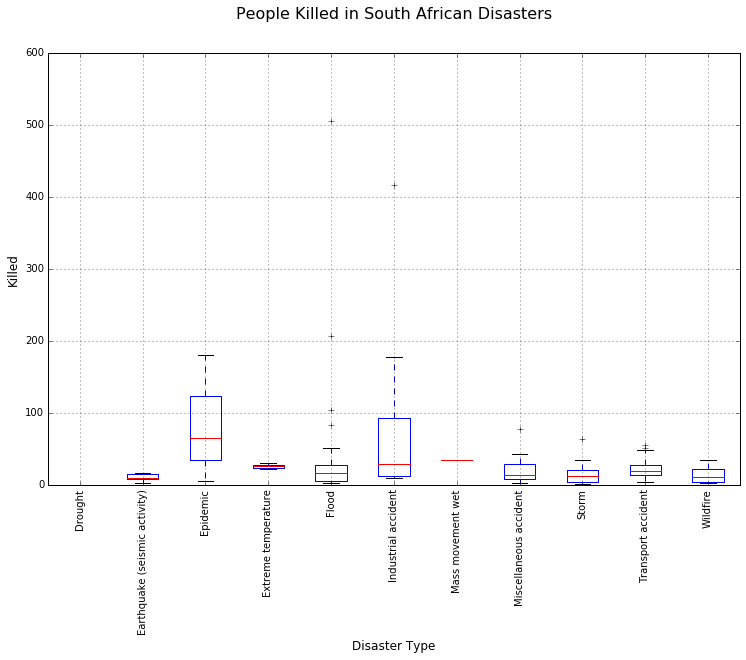

In [47]:
# Create a figure
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Show the number of people killed in South African disasters in a boxplot
bp = data[data.Country == "South Africa"].boxplot('Killed', by='Type', ax=ax, rot=90, return_type="axes")

# Set the title and axis labels
fig.suptitle('People Killed in South African Disasters', fontsize=16)
ax.set_title("")
ax.set_xlabel("Disaster Type", fontsize=12)
ax.set_ylabel("Killed", fontsize=12)

The boxplot shows:
- 4 outliers for Floods
- 1 outlier for Industrial accidents
- 1 outlier for Miscellaneous accidents
- 1 outlier for Storms
- 2 outliers for Transport accidents

Find the records with boxplot outlier values and find the Hampel Identifier outliers 

#### Method to Determine Boxplot Outliers

Method Name: boxplot

Input Parameters:
- values - a Pandas series containing the data for which outliers are to be determined

Return Value:
- A Pandas series of booleans indicating whether or not the corresponding element in values is an outlier

Description:

Determines the outliers in values using the boxplot method.
- Determine the 1st and 3rd quartiles
- Calculate the interquartile range
- Calculate the lower and upper whiskers as the 1st quartile - 1.5 * interquartile range and 3rd quartile + 1.5 * interquartile range respectively
- Test for outliers, which are values below the lower whisker or above the upper whisker and return a boolean series indicating whether or not the values are outliers

In [48]:
def boxplot(values):
    # Determine the 1st and 3rd quartiles
    quantiles = values[values.notnull()].quantile([0.25, 0.75])
    # Calculate the inter-quartile range
    iqr = quantiles[0.75] - quantiles[0.25]
    # Calculate the lower whisker
    lw = quantiles[0.25] - 1.5*iqr
    # Calculate the upper whisker
    uw = quantiles[0.75] + 1.5*iqr
    # Return a boolean series indicating which values are outliers
    return (values < lw) | (values > uw)

#### Method to Determine Boxplot Outliers

Method Name: hampel

"Though this be MADness, yet there is method in ’t" - Hamlet Act 2, Scene 2

Input Parameters:
- values - a Pandas series containing the data for which outliers are to be determined

Return Value:
- A Pandas series of booleans indicating whether or not the corresponding element in values is an outlier

Description:

Determines the outliers in values using the boxplot method.
- Determine the median
- For each value, Calculate the absolute distance from the median
- Find the median value of the absolute distances (MAD)
- Test for outliers, which are values less than 3\*MAD below the median or 3\*MAD above the median and return a boolean series indicating whether or not the values are outliers

In [49]:
def hampel(values):
    # Determine the median
    theMedian = values.median(skipna=True)
    # Calculate the absoluted distances from the median for each value
    ad = values.apply(lambda x: abs(x-theMedian))
    # Determine the median absolute distance
    mad = ad.median(skipna=True)
    # Return a boolean series indicating which values are outliers
    return (values < theMedian-3*mad) | (values > theMedian+3*mad)   

Find and print the outliers using boxplots and the Hampel Identifier, and generate a list of records that both methods have flagged as outliers

In [50]:
# Initialise a list variable to hold the indices of records flagged as outliers by both methods 
outliers = []

# Extract the records for South Africa and group by the type, then iterate through the groups
for Type, Group in data.loc[data.Country == "South Africa","Killed"].groupby(data["Type"]):
    # Get the boxplot outliers
    boxplotOutliers = boxplot(Group)
    # Get the Hampel Identifier outliers
    hampelOutliers = hampel(Group)
    # Find the records flagged as outliers by both methods
    bothOutliers = Group[hampelOutliers & boxplotOutliers].index
    # Print a summary of the outliers found
    print "Outliers for", Type
    if hampelOutliers.sum() == 0:
        print "No Hampel outliers"
    else:    
        print "Hampel outliers:\n", Group[hampelOutliers]
    if boxplotOutliers.sum() == 0:
        print "No boxplot outliers"
    else:    
        print "Boxplot outliers:\n", Group[boxplotOutliers]
    # Add the common outliers to the outliers list    
    if bothOutliers.size != 0:
        outliers.extend(bothOutliers.tolist())
    print    

Outliers for Drought
No Hampel outliers
No boxplot outliers

Outliers for Earthquake (seismic activity)
No Hampel outliers
No boxplot outliers

Outliers for Epidemic
No Hampel outliers
No boxplot outliers

Outliers for Extreme temperature
No Hampel outliers
No boxplot outliers

Outliers for Flood
Hampel outliers:
1369      51.0
4230     506.0
4251     207.0
12554     83.0
12944    104.0
Name: Killed, dtype: float64
Boxplot outliers:
4230     506.0
4251     207.0
12554     83.0
12944    104.0
Name: Killed, dtype: float64

Outliers for Industrial accident
Hampel outliers:
2220     129.0
4375     104.0
9918     177.0
11470    417.0
Name: Killed, dtype: float64
Boxplot outliers:
11470    417.0
Name: Killed, dtype: float64

Outliers for Mass movement wet
No Hampel outliers
No boxplot outliers

Outliers for Miscellaneous accident
Hampel outliers:
9885    77.0
Name: Killed, dtype: float64
Boxplot outliers:
9885    77.0
Name: Killed, dtype: float64

Outliers for Storm
Hampel outliers:
4924    

List the records found as outliers by both boxplots and the Hampel identifier:

In [51]:
data.loc[outliers,["Type","Sub_Type","Start","End","Location","Names","Killed"]]

,Type,Sub_Type,Start,End,Location,Names,Killed
4230,Flood,General flood,25091987,29091987,Natal:Kwazulu,NaN,506.0
4251,Flood,Flash flood,25121995,02011996,Pietermaritzburg region ( ...,NaN,207.0
12554,Flood,General flood,26012000,27032000,Northern Province:Mpumal ...,NaN,83.0
12944,Flood,NaN,01011981,31011981,Laingsburg:Cape province ...,NaN,104.0
11470,Industrial accident,Explosion,21011960,21011960,Coalbrook,Mine,417.0
9885,Miscellaneous accident,Collapse,22021994,22021994,Virginia,Dam,77.0
4924,Storm,Tropical cyclone,28011984,04021984,Natal:Kwazulu:Transvaal ...,Domoina:Imboa,64.0
3092,Transport accident,Road,02071989,02071989,Harding,NaN,56.0
13102,Transport accident,Road,01052003,01052003,Bethlehem (Libre state),NaN,51.0


## Task 3: Dealing with Missing Data

### Analysis of Missing Values

Which attributes have missing values?

In [52]:
# List count of null values in each column
data.isnull().sum()

Start                        0
End                          0
Country                      0
Location                  1890
Type                         0
Sub_Type                  1834
Names                     9786
Killed                    3048
Affected                  5461
Cost                     11317
International support     7416
ID                           0
Impact_area               7416
dtype: int64

Initial assessment of missing values by attribute

 Attribute             | Comment
 ----------------------|------------------------------------------------
 Start                 | No missing values
 End                   | No missing values
 Country               | No missing values
 Location              | About 13% of records are missing this attribute
 Type                  | No missing values
 Sub_Type              | About 13% of records are missing this attribute
 Names                 | About 68% of records are missing this attribute
 Killed                | About 21% of records are missing this attribute
 Affected              | About 38% of records are missing this attribute
 Cost                  | About 79% of records are missing this attribute
 International support | About 52% of records are missing this attribute
 ID                    | No missing values
 Impact_area           | About 52% of records are missing this attribute
 
- The attributes with a data type of object (Location, Sub_Type and Names) are probably best handled by imputing a value such as "not specified", so these attributes will not considered for deletion
- Are there missing values represented by a non-NaN value?
- International support and Impact_area have the same number of missing values, so there is probably a relationship here
- Killed and Affected need further investigation to see if there are patterns in the missing values
- Cost has a large number of missing values, so this column can potentially be deleted, but investigate further to see if there is value in keeping it

#### Are there missing values represented by a non-NaN value?

In [53]:
# Describe the numeric attributes
data[["Killed","Affected","Cost","International support","Impact_area"]].apply(lambda x: x.dropna().describe())

,Killed,Affected,Cost,International support,Impact_area
count,1.129500e+04,8.882000e+03,3026.000000,6927.000000,6.927000e+03
mean,2.803475e+03,5.916987e+05,482.936602,1014.615012,1.955283e+04
std,7.757319e+04,7.241085e+06,3320.469467,446.321671,2.348609e+05
min,1.000000e+00,1.000000e+00,0.003000,0.000000,0.000000e+00
25%,1.200000e+01,6.000000e+01,5.000000,696.833000,1.518000e+01
50%,2.400000e+01,1.000000e+03,35.000000,1075.338000,3.916000e+01
75%,5.600000e+01,2.000000e+04,200.000000,1323.697500,6.114500e+02
max,5.000000e+06,3.000000e+08,125000.000000,2801.093000,1.073480e+07


Looking at the minimum values for each attribute, both "International support" and "Impact_area" have records with a value of 0. That makes sense for "International support" - a disaster where no international support was supplied. But an "Impact_area" of 0 - a disaster that had no impact - doesn't sound right.

Take a closer look at these records

In [54]:
# Display records with an Impact_area of 0
data[data.Impact_area == 0]

,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
126,15092005,22092005,Philippines,Luzon:Muntinlupa:Pampan ...,Storm,Tropical cyclone,Damrey,16.0,20000.0,2.00,1125.886,2005-0540,0.0
1031,01051988,31051988,India,Northern:Western:Centra ...,Extreme temperature,Heat wave,NaN,418.0,200.0,NaN,780.164,1988-0183,0.0
2291,15031992,05041992,China,Guizhou province,Storm,Local storm,NaN,35.0,3300362.0,68.70,1928.989,1992-0126,0.0
2488,11112003,11112003,Saudi Arabia,Mecque,Flood,General flood,NaN,12.0,50.0,NaN,1285.331,2003-0538,0.0
5392,31052000,19062000,China,Awu:Jingmu:Hadapu (Long ...,Flood,Flash flood,NaN,34.0,154183.0,22.00,1296.767,2000-0302,0.0
5486,16052000,24052000,Indonesia,Malaka Tengah:Malaka Bar ...,Flood,Flash flood,NaN,126.0,50000.0,79.00,1117.310,2000-0258,0.0
6090,01012002,31012002,Togo,NaN,Epidemic,Bacterial infectious diseases,NaN,95.0,494.0,NaN,692.089,2002-0260,0.0
6547,01101999,31101999,Sudan,Kadugli (Southern Kordofa ...,Flood,NaN,NaN,2.0,23841.0,NaN,586.711,1999-0407,0.0
6925,03012005,03012005,Brazil,Criciuma,Storm,Local storm,NaN,2.0,344.0,NaN,1634.704,2005-0003,0.0
7497,29042004,29042004,Bangladesh,Keraniganj,Miscellaneous accident,Fire,Slum,4.0,3010.0,NaN,1041.604,2004-0683,0.0


Storms and floods that affected no area? This does not make sense, so it looks like 0 has been used as the default for missing "Impact_area" values for records where "International support" was provided.

Update the records to set the "Impact_area" to NaN where the "Impact_area" is 0.

In [55]:
# Update Impact_area values of 0 to null
data.loc[data.Impact_area == 0,"Impact_area"] = np.nan

# Display the number of records updated
print str((data["International support"].notnull() & data.Impact_area.isnull()).sum()), "records updated"

# Display the updated records
data[data["International support"].notnull() & data.Impact_area.isnull()]

28 records updated


,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,Cost,International support,ID,Impact_area
126,15092005,22092005,Philippines,Luzon:Muntinlupa:Pampan ...,Storm,Tropical cyclone,Damrey,16.0,20000.0,2.00,1125.886,2005-0540,NaN
1031,01051988,31051988,India,Northern:Western:Centra ...,Extreme temperature,Heat wave,NaN,418.0,200.0,NaN,780.164,1988-0183,NaN
2291,15031992,05041992,China,Guizhou province,Storm,Local storm,NaN,35.0,3300362.0,68.70,1928.989,1992-0126,NaN
2488,11112003,11112003,Saudi Arabia,Mecque,Flood,General flood,NaN,12.0,50.0,NaN,1285.331,2003-0538,NaN
5392,31052000,19062000,China,Awu:Jingmu:Hadapu (Long ...,Flood,Flash flood,NaN,34.0,154183.0,22.00,1296.767,2000-0302,NaN
5486,16052000,24052000,Indonesia,Malaka Tengah:Malaka Bar ...,Flood,Flash flood,NaN,126.0,50000.0,79.00,1117.310,2000-0258,NaN
6090,01012002,31012002,Togo,NaN,Epidemic,Bacterial infectious diseases,NaN,95.0,494.0,NaN,692.089,2002-0260,NaN
6547,01101999,31101999,Sudan,Kadugli (Southern Kordofa ...,Flood,NaN,NaN,2.0,23841.0,NaN,586.711,1999-0407,NaN
6925,03012005,03012005,Brazil,Criciuma,Storm,Local storm,NaN,2.0,344.0,NaN,1634.704,2005-0003,NaN
7497,29042004,29042004,Bangladesh,Keraniganj,Miscellaneous accident,Fire,Slum,4.0,3010.0,NaN,1041.604,2004-0683,NaN


#### What is the relationship between the missing values in the International support and Impact_area columns?

In [56]:
# Show the numbers of nulls for "International support" and "Impact_area" in a cross-tab
dataNulls = data[["International support","Impact_area"]].notnull().applymap(lambda x: "Not Null" if x else "Null")
pd.crosstab(dataNulls["International support"],dataNulls["Impact_area"])

Impact_area,Not Null,Null
International support,,
Not Null,6899,28
Null,0,7416


The above shows that apart from the 28 records updated by the previous step, either both International Support and Impact_area have values or neither of these have values. There are:
- 6899 records with values for both International Support and Impact_area
- 7416 records with values for neither International Support or Impact_area

#### Are there patterns to the missing values for Killed and Affected?

In [57]:
# Show the numbers of nulls for "Killed" and "Affected" versus "International support" in a cross-tab
dataNulls = data[["Killed","Affected","International support"]].notnull(). \
            applymap(lambda x: "Not Null" if x else "Null")
pd.crosstab([dataNulls["Killed"], dataNulls["Affected"]],
            [dataNulls["International support"]])

International support  Not Null  Null
Killed   Affected                    
Not Null Not Null          6927     0
         Null                 0  4368
Null     Not Null             0  1955
         Null                 0  1093

There are 6927 records with values for both Killed and Affected and these are the same records that have values for International Support.

There are 1093 (about 7.5%) records that do not have a value for any of the attributes Killed, Affected. These records do not have values for International support or Impact_area either.

Records without a value for either Killed or Affected are unlikely to provide any meaningful contribution to any analysis and so should be deleted.

#### Is there any value keeping the Cost column?

Very few records have a value for Cost, so this column can potentially be deleted. Before deleting it, some analysis is run to determine if it adds value where specified.

Is there any relationship between records with a "Cost" and records with "Killed" and "Affected" attributes?

In [58]:
# Show the number of nulls for "Cost" versus "Killed" and "Affected" in a cross-tab
dataNulls = data[["Killed","Affected","Cost"]].notnull().applymap(lambda x: "Not Null" if x else "Null")
pd.crosstab([dataNulls.Killed,dataNulls.Affected], dataNulls.Cost)

Cost               Not Null  Null
Killed   Affected                
Not Null Not Null      1819  5108
         Null           429  3939
Null     Not Null       425  1530
         Null           353   740

There doesn't appear to be any strong relationship between records that have a Cost and those that have Killed and/or Affected values.

There should be some correlation between "Cost" and "International support" when both these attributes are available

In [59]:
# Display details of Cost and International support to compare the distribution of values.
data[["Cost","International support"]].apply(lambda x: x.dropna().describe())

,Cost,International support
count,3026.000000,6927.000000
mean,482.936602,1014.615012
std,3320.469467,446.321671
min,0.003000,0.000000
25%,5.000000,696.833000
50%,35.000000,1075.338000
75%,200.000000,1323.697500
max,125000.000000,2801.093000


There is a lot more variation in the Cost values than in the International support values. Cost has mainly low values and a few very high values. International support looks more evenly distributed.

What about the ratio between "Cost" and "International support" - there should be a relationship between these. For example it should be unusual for the international support provided to be a lot higher than the cost of the disaster.

Plot the ratio of Cost to International Support to see if there is a relationship between these columns.

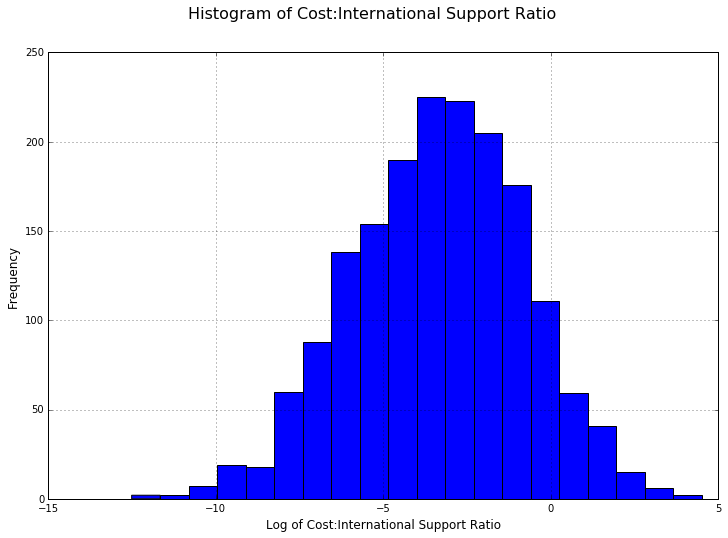

In [60]:
# Create a figure
fig = plt.figure(figsize=(12,8))

# Add a subplot
ax = fig.add_subplot(111)

# Show the distribution of the Cost:International Support ratio in a histogram
costSupportRatio = data.loc[data["International support"] > 0,["Cost","International support"]].dropna(). \
    apply(lambda x: x["Cost"]/x["International support"], axis=1)
costSupportRatio[(costSupportRatio > 0)].dropna().apply(np.log).hist(ax=ax, bins=20)

# Set the title and axis labels
fig.suptitle('Histogram of Cost:International Support Ratio', fontsize=16)
ax.set_title("")
ax.set_xlabel("Log of Cost:International Support Ratio", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

Note: Log scaling has been used in the above graph as the un-scaled data is highly skewed. Negative numbers mean that the "International support" value is higher than the "Cost" value.

The "Cost" values do not seem consistent, especially compared to "International support". If the numbers are taken at face value, there are disasters with low costs that got huge international support - several times the cost of the disaster, and a few with a high cost that got very little international support.

It looks like the "Cost" data is not reliable. It may be the cost in the local currency - in which case without the currency and the exchange rate the data has very little meaning.

On this basis, combined with the fact that very few records have a cost, the cost column should be dropped.

### Task 3.1: Delete Missing Values

Based on the above analysis of the null values, the following steps are used to handle missing values by deletion:
1. Drop the "Cost" column as there are only a few records that have a value for Cost and the quality of the Cost data does not appear to be good.
2. Delete records if they have neither a Killed nor an Affected value. These records do not have values for "International support" or "Impact_area" either, so once the Cost column has been dropped they have no numerical data.

In [61]:
# Drop the "Cost" column
data.drop("Cost", axis=1, inplace=True)

# Delete records with neither a Killed nor an Affected value
data = data[data.Killed.notnull() | data.Affected.notnull()]

# Show the resulting Dataframe structure
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13250 entries, 0 to 14349
Data columns (total 12 columns):
Start                    13250 non-null object
End                      13250 non-null object
Country                  13250 non-null object
Location                 11765 non-null object
Type                     13250 non-null object
Sub_Type                 11640 non-null object
Names                    4278 non-null object
Killed                   11295 non-null float64
Affected                 8882 non-null float64
International support    6927 non-null float64
ID                       13250 non-null object
Impact_area              6899 non-null float64
dtypes: float64(4), object(8)
memory usage: 1.3+ MB


### Task 3.2 Imputation

In [62]:
# Import the library containing the regression and prediction methods
import regression

#### Train the Regression Model

Extract the data with all of the "Country","Type","Killed","Affected" and "Impact_area" and split into training and test datasets.

In [63]:
# Extract the data used to train the regression model and split into training and test dataframes
dataTrain, dataTest = train_test_split(data[["Country","Type","Killed","Affected","Impact_area"]].dropna())

# Check the results
print dataTrain.info()
print dataTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5174 entries, 7728 to 12813
Data columns (total 5 columns):
Country        5174 non-null object
Type           5174 non-null object
Killed         5174 non-null float64
Affected       5174 non-null float64
Impact_area    5174 non-null float64
dtypes: float64(3), object(2)
memory usage: 242.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1725 entries, 13698 to 10813
Data columns (total 5 columns):
Country        1725 non-null object
Type           1725 non-null object
Killed         1725 non-null float64
Affected       1725 non-null float64
Impact_area    1725 non-null float64
dtypes: float64(3), object(2)
memory usage: 80.9+ KB
None


Train the linear regression model

In [64]:
# Train the regression model
dataModel = regression.train(df=dataTrain)

Standard error: 13.40


#### Impute the Missing Values

Extract the records that should have the Impact_area imputed

In [65]:
# Make a copy of the dataframe
dataImpute = data.loc[data.Impact_area.isnull(),["Country","Type","Killed","Affected"]].dropna()
# Check the result
dataImpute.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 126 to 14289
Data columns (total 4 columns):
Country     28 non-null object
Type        28 non-null object
Killed      28 non-null float64
Affected    28 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.1+ KB


Use the linear regression model to impute the Impact_area

In [66]:
# Impute the Impact_area
dataImpute["Impact_area"] = regression.predict(model=dataModel , df=dataImpute)

# Check the imputation results
dataImpute

,Country,Type,Killed,Affected,Impact_area
126,Philippines,Storm,16.0,20000.0,722.844018
1031,India,Extreme temperature,418.0,200.0,31.314732
2291,China,Storm,35.0,3300362.0,118103.197674
2488,Saudi Arabia,Flood,12.0,50.0,14.173334
5392,China,Flood,34.0,154183.0,5530.364834
5486,Indonesia,Flood,126.0,50000.0,1806.504659
6090,Togo,Epidemic,95.0,494.0,23.785764
6547,Sudan,Flood,2.0,23841.0,862.726322
6925,Brazil,Storm,2.0,344.0,13.476353
7497,Bangladesh,Miscellaneous accident,4.0,3010.0,122.975437


#### Update the Data Dataframe

Update the dataframe with the predicted values, rounded to 2 decimal places for consistency with other data and add a column to flag the records with an imputed Impact_area

In [67]:
# Update the dataframe
data.loc[dataImpute.index,"Impact_area"] = dataImpute.Impact_area.apply(lambda x: round(x,2))

# Add the new flag column
data["Imputed Impact_area"] = False

# Set the flag column to True for the records with an imputed Impact_area
data.loc[dataImpute.index,"Imputed Impact_area"] = True

# Check the correct number of records are flagged
print str(data["Imputed Impact_area"].sum()), "records with imputed Impact_area"

# Display the records
data.loc[data["Imputed Impact_area"],]

28 records with imputed Impact_area


,Start,End,Country,Location,Type,Sub_Type,Names,Killed,Affected,International support,ID,Impact_area,Imputed Impact_area
126,15092005,22092005,Philippines,Luzon:Muntinlupa:Pampan ...,Storm,Tropical cyclone,Damrey,16.0,20000.0,1125.886,2005-0540,722.84,True
1031,01051988,31051988,India,Northern:Western:Centra ...,Extreme temperature,Heat wave,NaN,418.0,200.0,780.164,1988-0183,31.31,True
2291,15031992,05041992,China,Guizhou province,Storm,Local storm,NaN,35.0,3300362.0,1928.989,1992-0126,118103.20,True
2488,11112003,11112003,Saudi Arabia,Mecque,Flood,General flood,NaN,12.0,50.0,1285.331,2003-0538,14.17,True
5392,31052000,19062000,China,Awu:Jingmu:Hadapu (Long ...,Flood,Flash flood,NaN,34.0,154183.0,1296.767,2000-0302,5530.36,True
5486,16052000,24052000,Indonesia,Malaka Tengah:Malaka Bar ...,Flood,Flash flood,NaN,126.0,50000.0,1117.310,2000-0258,1806.50,True
6090,01012002,31012002,Togo,NaN,Epidemic,Bacterial infectious diseases,NaN,95.0,494.0,692.089,2002-0260,23.79,True
6547,01101999,31101999,Sudan,Kadugli (Southern Kordofa ...,Flood,NaN,NaN,2.0,23841.0,586.711,1999-0407,862.73,True
6925,03012005,03012005,Brazil,Criciuma,Storm,Local storm,NaN,2.0,344.0,1634.704,2005-0003,13.48,True
7497,29042004,29042004,Bangladesh,Keraniganj,Miscellaneous accident,Fire,Slum,4.0,3010.0,1041.604,2004-0683,122.98,True


### End of Task 3

Show a summary of the data frame attributes as at the end of task 3.

In [68]:
# Describe the numeric values
data[["Killed","Affected","International support","Impact_area"]].apply(lambda x: x.dropna().describe())

,Killed,Affected,International support,Impact_area
count,1.129500e+04,8.882000e+03,6927.000000,6.927000e+03
mean,2.803475e+03,5.916987e+05,1014.615012,1.958981e+04
std,7.757319e+04,7.241085e+06,446.321671,2.348653e+05
min,1.000000e+00,1.000000e+00,0.000000,1.000000e-02
25%,1.200000e+01,6.000000e+01,696.833000,1.537000e+01
50%,2.400000e+01,1.000000e+03,1075.338000,3.960000e+01
75%,5.600000e+01,2.000000e+04,1323.697500,6.315550e+02
max,5.000000e+06,3.000000e+08,2801.093000,1.073480e+07


In [69]:
# Described the non-numeric values
data.describe(include=["object","bool"])

,Start,End,Country,Location,Type,Sub_Type,Names,ID,Imputed Impact_area
count,13250,13250,13250,11765,13250,11640,4278,13250,13250
unique,7387,7440,220,10012,15,37,2140,12805,2
top,01012006,31122001,China,North,Transport accident,Road,Coal mine,2002-0858,False
freq,30,26,1072,48,3516,1562,285,19,13222


### Write the Dataframe to a CSV File

In [70]:
# Make a copy of the data frame
data_formatted = data.copy()
# Format the Killed column 
data_formatted["Killed"] = data_formatted["Killed"].map(lambda x: '%1.0f' % x, na_action="ignore")
# Format the Affected column
data_formatted["Affected"] = data_formatted["Affected"].map(lambda x: '%1.0f' % x, na_action="ignore")
# Write the formatted data frame to a CSV file
data_formatted.to_csv("Disasters_data_cleaned.csv")